# 2kr Analysis

In [1]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product, chain, combinations
from scipy import stats
from IPython.display import display, HTML
%matplotlib inline

def parse_if_number(s):
    try: return float(s)
    except: return True if s=="true" else False if s=="false" else s if s else None

def parse_ndarray(s):
    return np.fromstring(s, sep=' ') if s else None

def get_file_name(name):
    return name.replace(':', '-')

## Config

In [2]:
inputFile = 'data.csv'
repetitionsCount = -1 # -1 = auto-detect
factors = ['R', 'T', 'm', 'D']

tIntervalAlpha = 0.95

plotSize = (10, 10)
plotStyle = 'seaborn-whitegrid'
saveFigures = False

# Filter scalars
scalarsFilter = ['Floorplan.userCount', 'Floorplan.coveredUsers:sum', 'Floorplan.collisions:sum', 'Floorplan.msgsPerSlot:sum']
# Filter vectors
vectorsFilter = ['Floorplan.coveredUsers:vector']
# Percentiles
percentiles = [0.25, 0.5, 0.75, 0.9, 0.95, 0.99]

# Performance indexes
perfIndexes = [
    ('coveredUsersPercent', 'percentage of covered users'),
    ('Floorplan.collisions:sum', 'total number of collisions'),
    ('Floorplan.msgsPerSlot:sum', 'total number of messages sent'),
]

# Transformations
transformations = [
]

intPercentiles = [int(i*100) for i in percentiles]
vecPerfIndexes = []
for intPercentile in intPercentiles:
    vecPerfIndexes.append(('broadcastTime' + str(intPercentile), 'Broadcast time needed to reach the ' + str(intPercentile) + 'th percentile of the coverage'))
for v in vecPerfIndexes:
    perfIndexes.append(v)
    transformations.append((v[0], lambda x: math.log(x)))

## Load scalars

In [3]:
df = pd.read_csv('exported_data/' + inputFile, converters = {
    'attrvalue': parse_if_number,
    'binedges': parse_ndarray,
    'binvalues': parse_ndarray,
    'vectime': parse_ndarray,
    'vecvalue': parse_ndarray,
})

In [4]:
if repetitionsCount <= 0: # auto-detect
    repetitionsCount = int(df[df.attrname == 'repetition']['attrvalue'].max()) + 1
print('Repetitions:', repetitionsCount)

# Computed
factorsCount = len(factors)
configsCount = 2**factorsCount
totalSims = configsCount*repetitionsCount

combinedFactors = list(chain(*[list(map(''.join, combinations(''.join(factors), i))) for i in range(1, factorsCount+1)]))
freedomDegrees = configsCount*(repetitionsCount - 1)


display(HTML("<style>div.output_scroll { height: auto; max-height: 48em; }</style>"))
pd.set_option('display.max_rows', totalSims)
pd.set_option('display.max_columns', 2*configsCount*repetitionsCount+1)
if saveFigures:
    os.makedirs('figures', exist_ok=True)

Repetitions: 10


In [5]:
scalars = df[(df.type == 'scalar') | ((df.type == 'itervar') & (df.attrname != 'TO')) | ((df.type == 'param') & (df.attrname == 'Floorplan.userCount')) | ((df.type == 'runattr') & (df.attrname == 'repetition'))]
scalars = scalars.assign(qname = scalars.attrname.combine_first(scalars.module + '.' + scalars.name))
for index, row in scalars[scalars.type == 'itervar'].iterrows():
    val = scalars.loc[index, 'attrvalue']
    if isinstance(val, str)  and not all(c.isdigit() for c in val):
        scalars.loc[index, 'attrvalue'] = eval(val)
scalars.value = scalars.value.combine_first(scalars.attrvalue.astype('float64'))
scalars_wide = scalars.pivot_table(index=['run'], columns='qname', values='value')
scalars_wide.sort_values([*factors, 'repetition'], inplace=True)
count = 0
for index in scalars_wide.index:
    config = count // repetitionsCount
    scalars_wide.loc[index, 'config'] = config
    count += 1
scalars_wide = scalars_wide[['config', 'repetition', *factors, *scalarsFilter]]

# coverage
scalars_wide['coveredUsersPercent'] = scalars_wide['Floorplan.coveredUsers:sum'] / (scalars_wide['Floorplan.userCount'] - 1)

## Load vectors

In [6]:
vectors = df[df.type == 'vector']
vectors = vectors.assign(qname = vectors.module + '.' + vectors.name)
for index in scalars_wide.index:
    r = index
    cfg = scalars_wide.loc[index, 'config']
    rep = scalars_wide.loc[index, 'repetition']
    vectors.loc[vectors.run == r, 'config'] = cfg
    vectors.loc[vectors.run == r, 'repetition'] = rep
vectors = vectors[vectors.qname.isin(vectorsFilter)]
vectors.sort_values(['config', 'repetition', 'qname'], inplace=True)
vectors = vectors[['config', 'repetition', 'qname', 'vectime', 'vecvalue']]

## Compute scalars from vectors

In [7]:
def get_percentile(percentile, vectime, vecvalue, totalvalue):
    tofind = percentile * totalvalue
    idx = 0
    csum = vecvalue.cumsum()
    for value in csum:
        if value >= tofind:
            return vectime[idx]
        idx += 1
    return math.inf

for index, row in vectors.iterrows():
    for vecPerf, percentile in zip(vecPerfIndexes, percentiles):
        vecPerfIndex = vecPerf[0]
        cfg = row['config']
        rep = row['repetition']
        if vecPerfIndex.startswith('broadcastTime'):
            total = scalars_wide[(scalars_wide['config'] == cfg) & (scalars_wide['repetition'] == rep)]['Floorplan.userCount'].values[0] - 1
        else:
            raise Exception('Need to specify total for ' + vecPerfIndex + '. (coding required)')
        value = get_percentile(percentile, row['vectime'], row['vecvalue'], total)
        scalars_wide.loc[(scalars_wide['config'] == cfg) & (scalars_wide['repetition'] == rep), vecPerfIndex] = value

## Apply transformations

In [8]:
for col, transform in transformations:
    scalars_wide[col] = scalars_wide[col].map(transform, 'ignore')

## 2kr

In [9]:
cols = ['exp', 'I'] + combinedFactors
data = [[e, 1] + list(chain(*[list(map(np.prod, combinations(r, i))) for i in range(1, len(r)+1)])) for r,e in zip([list(x) for x in product([-1, 1], repeat=factorsCount)], range(0, configsCount))]
factorsMatrix = pd.DataFrame.from_records(data, columns=cols, index='exp')

computeMatrices = []
ciMatrices = []
errorVariances = []
skipped = []

for perfIndex, perfIndexDesc in perfIndexes:
    print("2^k*r analysis for the", perfIndexDesc)
    cols = ['exp'] + ['y' + str(i) for i in range(0, repetitionsCount)]
    data = [[i] + scalars_wide[scalars_wide.config == i][perfIndex].values.tolist() for i in range(0, configsCount)]
    ysMatrix = pd.DataFrame.from_records(data, columns=cols, index='exp')
    ysMatrix['mean'] = ysMatrix.mean(axis=1)
    next2kr = False
    for r in range(0, repetitionsCount):
        for c in range(0, configsCount):
            if math.isinf(ysMatrix['y' + str(r)].values[c]):
                print('!!! Observations contain infinite values. Skipping...')
                print()
                skipped.append(perfIndex)
                next2kr = True
                break
        if next2kr:
            break
        ysMatrix['e' + str(r)] = ysMatrix['y' + str(r)] - ysMatrix['mean']
    if next2kr:
        continue

    matrix = pd.concat([factorsMatrix, ysMatrix], axis=1)

    computeCols = ['idx', 'I'] + combinedFactors + ['e' + str(r) for r in range(0, repetitionsCount)]
    data = [['Sum'], ['Mean (Qi)'], ['SSQ']]
    SSE = 0
    for col in computeCols[1:]:
        sumvalue = np.sum(matrix[col].values * matrix['mean'].values)
        data[0].append(sumvalue)
        data[1].append(sumvalue / configsCount)
        if col in ['e' + str(r) for r in range(0, repetitionsCount)]:
            ssq = np.sum(matrix[col].values * matrix[col].values)
            data[2].append(ssq)
            SSE += ssq
        else:
            data[2].append('')
    computeMatrix = pd.DataFrame.from_records(data, columns=computeCols, index='idx')

    data = [['(2^k)*r*(qi)^2'], ['Variation'], ['Variation%']]
    SST = SSE
    for col in combinedFactors:
        qi = computeMatrix.loc['Mean (Qi)', col]
        r2kqi2 = configsCount*repetitionsCount*(qi**2)
        data[0].append(r2kqi2)
        SST += r2kqi2
    data[0].append(SSE)
    idx = 1
    for col in combinedFactors:
        r2kqi2 = data[0][idx]
        var = r2kqi2 / SST
        data[1].append(var)
        data[2].append('{:.2%}'.format(var))
        idx += 1
    data[1].append(SST)
    data[2].append('{:.2%}'.format(SSE/SST))
    resultMatrix = pd.DataFrame.from_records(data, columns=['idx'] + combinedFactors + ['SSE/SST'], index='idx')

    errorVariance = SSE / freedomDegrees
    negativeInterval, positiveInterval = tuple(v*math.sqrt(errorVariance/(configsCount*repetitionsCount)) for v in stats.t.interval(tIntervalAlpha, freedomDegrees))
    data = [['CI+ Qi ({:.2%})'.format(tIntervalAlpha)], ['CI- Qi ({:.2%})'.format(tIntervalAlpha)], ['Distance (Qi)'], ['Zero Included'], ['CI+ Variation'], ['CI- Variation'], ['CI Distance (Variation)']]
    for col in combinedFactors:
        qi = computeMatrix.loc['Mean (Qi)', col]
        upper = qi + positiveInterval
        lower = qi + negativeInterval
        data[0].append(upper)
        data[1].append(lower)
        data[2].append(abs(upper - lower))
        data[3].append(upper >= 0 and lower <= 0)
        upper = (configsCount*repetitionsCount*(upper**2))/SST
        lower = (configsCount*repetitionsCount*(lower**2))/SST
        data[4].append(upper)
        data[5].append(lower)
        data[6].append(abs(upper - lower))
    ciMatrix = pd.DataFrame.from_records(data, columns=['idx'] + combinedFactors, index='idx')

    computeMatrices.append(computeMatrix)
    ciMatrices.append(ciMatrix)
    errorVariances.append(errorVariance)

    display(matrix)
    display(computeMatrix)
    display(resultMatrix)
    display(ciMatrix)

    print('SSE =', SSE)
    print('SST =', SST)
    print('Error variance =', errorVariance)
    print('Unexplained Variation =', '{:.2%}'.format(SSE/SST))
    print()
    print('####################################')
    print()

2^k*r analysis for the percentage of covered users


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,1.000000,0.999199,0.997598,0.997598,1.000000,0.995196,1.000000,0.998399,1.000000,1.000000,0.998799,0.001201,0.000400,-0.001201,-0.001201,0.001201,-0.003603,0.001201,-0.00040,0.001201,0.001201
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,1.000000,0.998399,0.995997,1.000000,1.000000,0.999199,1.000000,0.999199,1.000000,1.000000,0.999279,0.000721,-0.000881,-0.003283,0.000721,0.000721,-0.000080,0.000721,-0.00008,0.000721,0.000721
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,1.000000,1.000000,0.999199,1.000000,1.000000,1.000000,1.000000,1.000000,0.999199,1.000000,0.999840,0.000160,0.000160,-0.000641,0.000160,0.000160,0.000160,0.000160,0.00016,-0.000641,0.000160
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,1.000000,1.000000,0.998399,1.000000,1.000000,1.000000,1.000000,0.999199,1.000000,1.000000,0.999760,0.000240,0.000240,-0.001361,0.000240,0.000240,0.000240,0.000240,-0.00056,0.000240,0.000240
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,0.994396,0.999199,0.991994,0.997598,1.000000,0.998399,0.999199,0.998399,1.000000,0.999199,0.997838,-0.003443,0.001361,-0.005845,-0.000240,0.002162,0.000560,0.001361,0.00056,0.002162,0.001361
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,0.998399,0.998399,1.000000,1.000000,0.999199,1.000000,1.000000,1.000000,1.000000,1.000000,0.999600,-0.001201,-0.001201,0.000400,0.000400,-0.000400,0.000400,0.000400,0.00040,0.000400,0.000400
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,0.999199,0.999199,1.000000,1.000000,0.995997,0.998399,1.000000,0.999199,1.000000,1.000000,0.999199,0.000000,0.000000,0.000801,0.000801,-0.003203,-0.000801,0.000801,0.00000,0.000801,0.000801
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,0.999199,0.999199,0.997598,1.000000,1.000000,0.999199,1.000000,0.999199,0.998399,0.997598,0.999039,0.000160,0.000160,-0.001441,0.000961,0.000961,0.000160,0.000961,0.00016,-0.000641,-0.001441


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,15.991914,0.003283,-0.000881,0.005044,0.005204,0.001201,-0.001521,-0.000721,0.000721,0.001841,-0.003122,0.00024,-0.002482,-0.00008,-0.000721,0.00008,-0.006315,0.000878,-0.013512,0.000880,0.003277,-0.001519,0.005678,0.000879,0.005677,0.004078
Mean (Qi),0.999495,0.000205,-0.000055,0.000315,0.000325,0.000075,-0.000095,-0.000045,0.000045,0.000115,-0.000195,0.000015,-0.000155,-0.000005,-0.000045,0.000005,-0.000395,0.000055,-0.000845,0.000055,0.000205,-0.000095,0.000355,0.000055,0.000355,0.000255
SSQ,,,,,,,,,,,,,,,,,0.000030,0.000005,0.000053,0.000007,0.000019,0.000015,0.000006,0.000001,0.000010,0.000008


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,0.000007,0.0,0.000016,0.000017,0.000001,0.000001,0.0,0.0,0.000002,0.000006,0.0,0.000004,0.0,0.0,0.0,0.000154
Variation,0.032105,0.002311,0.075804,0.080693,0.004297,0.006895,0.001547,0.001547,0.010103,0.029049,0.000172,0.018354,0.000019,0.001547,0.000019,0.00021
Variation%,3.21%,0.23%,7.58%,8.07%,0.43%,0.69%,0.15%,0.15%,1.01%,2.90%,0.02%,1.84%,0.00%,0.15%,0.00%,73.55%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),0.000367,0.000107,0.000477,0.000487,0.000237,0.000067,0.000117,0.000207,0.000277,-0.000033,0.000177,0.000007,0.000157,0.000117,0.000167
CI- Qi (95.00%),0.000043,-0.000217,0.000154,0.000164,-0.000087,-0.000257,-0.000207,-0.000117,-0.000047,-0.000357,-0.000147,-0.000317,-0.000167,-0.000207,-0.000157
Distance (Qi),0.000324,0.000324,0.000324,0.000324,0.000324,0.000324,0.000324,0.000324,0.000324,0.000324,0.000324,0.000324,0.000324,0.000324,0.000324
Zero Included,False,True,False,False,True,True,True,True,True,False,True,True,True,True,True
CI+ Variation,0.102685,0.008685,0.173547,0.180906,0.042774,0.003391,0.01039,0.032615,0.058458,0.000851,0.023832,0.000033,0.01874,0.01039,0.02121
CI- Variation,0.001438,0.035849,0.017972,0.020392,0.005732,0.05031,0.032615,0.01039,0.001661,0.097159,0.016424,0.076586,0.02121,0.032615,0.01874
CI Distance (Variation),0.101247,0.027164,0.155575,0.160514,0.037042,0.046919,0.022225,0.022225,0.056797,0.096308,0.007408,0.076553,0.002469,0.022225,0.002469


SSE = 0.00015429477288796486
SST = 0.00020977150014647565
Error variance = 1.0714914783886448e-06
Unexplained Variation = 73.55%

####################################

2^k*r analysis for the total number of collisions


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,613.0,631.0,687.0,666.0,648.0,660.0,675.0,576.0,558.0,545.0,625.9,-12.9,5.1,61.1,40.1,22.1,34.1,49.1,-49.9,-67.9,-80.9
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,458.0,393.0,408.0,395.0,388.0,380.0,363.0,442.0,453.0,365.0,404.5,53.5,-11.5,3.5,-9.5,-16.5,-24.5,-41.5,37.5,48.5,-39.5
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,953.0,930.0,905.0,952.0,900.0,1069.0,931.0,1023.0,924.0,981.0,956.8,-3.8,-26.8,-51.8,-4.8,-56.8,112.2,-25.8,66.2,-32.8,24.2
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,579.0,545.0,577.0,533.0,593.0,579.0,559.0,541.0,572.0,607.0,568.5,10.5,-23.5,8.5,-35.5,24.5,10.5,-9.5,-27.5,3.5,38.5
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,551.0,659.0,524.0,641.0,576.0,498.0,606.0,573.0,543.0,564.0,573.5,-22.5,85.5,-49.5,67.5,2.5,-75.5,32.5,-0.5,-30.5,-9.5
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,323.0,335.0,379.0,372.0,423.0,279.0,390.0,351.0,334.0,402.0,358.8,-35.8,-23.8,20.2,13.2,64.2,-79.8,31.2,-7.8,-24.8,43.2
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,910.0,931.0,986.0,880.0,950.0,904.0,863.0,896.0,918.0,845.0,908.3,1.7,22.7,77.7,-28.3,41.7,-4.3,-45.3,-12.3,9.7,-63.3
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,636.0,601.0,619.0,634.0,612.0,588.0,618.0,650.0,662.0,611.0,623.1,12.9,-22.1,-4.1,10.9,-11.1,-35.1,-5.1,26.9,38.9,-12.1
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,1710.0,2013.0,1896.0,2089.0,1818.0,1940.0,1820.0,2158.0,1877.0,2077.0,1939.8,-229.8,73.2,-43.8,149.2,-121.8,0.2,-119.8,218.2,-62.8,137.2


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,23142.8,13104.0,57.0,7489.6,-4633.8,241.0,5301.6,-2414.6,1271.4,766.8,-1233.0,1063.0,547.2,-758.2,509.6,316.8,925151.26000,-213894.34000,-1.010233e+06,-252484.94000,-628254.14000,1.726526e+06,-1.795709e+06,-46567.04,-262939.74000,1.558405e+06
Mean (Qi),1446.425,819.0,3.5625,468.1,-289.6125,15.0625,331.35,-150.9125,79.4625,47.925,-77.0625,66.4375,34.2,-47.3875,31.85,19.8,57821.95375,-13368.39625,-6.313958e+04,-15780.30875,-39265.88375,1.079079e+05,-1.122318e+05,-2910.44,-16433.73375,9.740034e+04
SSQ,,,,,,,,,,,,,,,,,158506.74000,96856.94000,6.418794e+04,71293.14000,121853.54000,1.473349e+05,1.110049e+05,180884.34,26208.74000,1.784433e+05


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,107321760.0,2030.625,35058817.6,13420064.025,36300.625,17566851.6,3643933.225,1010286.225,367488.9,950180.625,706230.625,187142.4,359292.025,162307.6,62726.4,1156574.6
Variation,0.589641,0.000011,0.192618,0.073732,0.000199,0.096515,0.02002,0.005551,0.002019,0.00522,0.00388,0.001028,0.001974,0.000892,0.000345,182011987.1
Variation%,58.96%,0.00%,19.26%,7.37%,0.02%,9.65%,2.00%,0.56%,0.20%,0.52%,0.39%,0.10%,0.20%,0.09%,0.03%,0.64%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),833.004219,17.566719,482.104219,-275.608281,29.066719,345.354219,-136.908281,93.466719,61.929219,-63.058281,80.441719,48.204219,-33.383281,45.854219,33.804219
CI- Qi (95.00%),804.995781,-10.441719,454.095781,-303.616719,1.058281,317.345781,-164.916719,65.458281,33.920781,-91.066719,52.433281,20.195781,-61.391719,17.845781,5.795781
Distance (Qi),28.008438,28.008438,28.008438,28.008438,28.008438,28.008438,28.008438,28.008438,28.008438,28.008438,28.008438,28.008438,28.008438,28.008438,28.008438
Zero Included,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
CI+ Variation,0.609978,0.000271,0.204316,0.066774,0.000743,0.104845,0.016477,0.00768,0.003371,0.003495,0.005688,0.002043,0.00098,0.001848,0.001005
CI- Variation,0.569649,0.000096,0.181265,0.081035,0.000001,0.088529,0.023908,0.003767,0.001011,0.00729,0.002417,0.000359,0.003313,0.00028,0.00003
CI Distance (Variation),0.040329,0.000175,0.02305,0.014261,0.000742,0.016316,0.007431,0.003913,0.00236,0.003795,0.003272,0.001684,0.002333,0.001568,0.000975


SSE = 1156574.5999999999
SST = 182011987.1
Error variance = 8031.768055555554
Unexplained Variation = 0.64%

####################################

2^k*r analysis for the total number of messages sent


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,849.0,881.0,895.0,890.0,876.0,884.0,913.0,890.0,884.0,873.0,883.5,-34.5,-2.5,11.5,6.5,-7.5,0.5,29.5,6.5,0.5,-10.5
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,951.0,944.0,934.0,933.0,936.0,927.0,924.0,955.0,937.0,923.0,936.4,14.6,7.6,-2.4,-3.4,-0.4,-9.4,-12.4,18.6,0.6,-13.4
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,1250.0,1250.0,1249.0,1250.0,1250.0,1250.0,1250.0,1250.0,1249.0,1250.0,1249.8,0.2,0.2,-0.8,0.2,0.2,0.2,0.2,0.2,-0.8,0.2
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,1250.0,1250.0,1248.0,1250.0,1250.0,1250.0,1250.0,1249.0,1250.0,1250.0,1249.7,0.3,0.3,-1.7,0.3,0.3,0.3,0.3,-0.7,0.3,0.3
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,804.0,849.0,812.0,831.0,856.0,829.0,861.0,843.0,824.0,824.0,833.3,-29.3,15.7,-21.3,-2.3,22.7,-4.3,27.7,9.7,-9.3,-9.3
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,765.0,814.0,795.0,795.0,808.0,753.0,807.0,805.0,799.0,801.0,794.2,-29.2,19.8,0.8,0.8,13.8,-41.2,12.8,10.8,4.8,6.8
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,1237.0,1241.0,1246.0,1240.0,1239.0,1238.0,1244.0,1236.0,1241.0,1239.0,1240.1,-3.1,0.9,5.9,-0.1,-1.1,-2.1,3.9,-4.1,0.9,-1.1
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,1238.0,1236.0,1234.0,1239.0,1237.0,1242.0,1240.0,1238.0,1238.0,1237.0,1237.9,0.1,-1.9,-3.9,1.1,-0.9,4.1,2.1,0.1,0.1,-0.9
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,671.0,702.0,646.0,687.0,674.0,682.0,662.0,719.0,670.0,736.0,684.9,-13.9,17.1,-38.9,2.1,-10.9,-2.9,-22.9,34.1,-14.9,51.1


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,15766.9,-1082.9,-660.9,3898.5,-79.5,-233.1,838.3,-102.5,329.9,-236.1,28.9,-11.9,-47.9,61.1,184.3,4.5,-37531.930000,56772.470000,-51501.130000,-18389.130000,-12278.430000,7345.870000,-19669.930000,59236.970000,-17240.430000,33255.670000
Mean (Qi),985.43125,-67.68125,-41.30625,243.65625,-4.96875,-14.56875,52.39375,-6.40625,20.61875,-14.75625,1.80625,-0.74375,-2.99375,3.81875,11.51875,0.28125,-2345.745625,3548.279375,-3218.820625,-1149.320625,-767.401875,459.116875,-1229.370625,3702.310625,-1077.526875,2078.479375
SSQ,,,,,,,,,,,,,,,,,5789.330000,2613.530000,3277.730000,2377.730000,2693.330000,2650.730000,4392.330000,2470.530000,2762.330000,5654.130000


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,732920.25625,272993.00625,9498938.90625,3950.15625,33959.75625,439216.80625,6566.40625,68021.25625,34839.50625,522.00625,88.50625,1434.00625,2333.25625,21229.05625,12.65625,34681.7
Variation,0.065723,0.02448,0.851792,0.000354,0.003045,0.039386,0.000589,0.0061,0.003124,0.000047,0.000008,0.000129,0.000209,0.001904,0.000001,11151707.24375
Variation%,6.57%,2.45%,85.18%,0.04%,0.30%,3.94%,0.06%,0.61%,0.31%,0.00%,0.00%,0.01%,0.02%,0.19%,0.00%,0.31%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),-65.256191,-38.881191,246.081309,-2.543691,-12.143691,54.818809,-3.981191,23.043809,-12.331191,4.231309,1.681309,-0.568691,6.243809,13.943809,2.706309
CI- Qi (95.00%),-70.106309,-43.731309,241.231191,-7.393809,-16.993809,49.968691,-8.831309,18.193691,-17.181309,-0.618809,-3.168809,-5.418809,1.393691,9.093691,-2.143809
Distance (Qi),4.850117,4.850117,4.850117,4.850117,4.850117,4.850117,4.850117,4.850117,4.850117,4.850117,4.850117,4.850117,4.850117,4.850117,4.850117
Zero Included,False,False,False,False,False,False,False,False,False,True,True,False,False,False,True
CI+ Variation,0.061097,0.02169,0.868832,0.000093,0.002116,0.043116,0.000227,0.007619,0.002182,0.000257,0.000041,0.000005,0.000559,0.00279,0.000105
CI- Variation,0.070517,0.027439,0.834921,0.000784,0.004143,0.035824,0.001119,0.004749,0.004235,0.000005,0.000144,0.000421,0.000028,0.001186,0.000066
CI Distance (Variation),0.00942,0.005749,0.033911,0.000692,0.002028,0.007292,0.000892,0.00287,0.002054,0.000251,0.000104,0.000417,0.000531,0.001603,0.000039


SSE = 34681.700000000004
SST = 11151707.24375
Error variance = 240.84513888888893
Unexplained Variation = 0.31%

####################################

2^k*r analysis for the Broadcast time needed to reach the 25th percentile of the coverage


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,4.330733,3.737670,4.060443,3.850148,3.784190,4.189655,4.330733,4.174387,4.290459,4.290459,4.103888,0.226846,-0.366218,-0.043445,-0.253740,-0.319698,0.085767,0.226846,0.070500,0.186572,0.186572
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,4.219508,4.143135,4.007333,4.143135,4.382027,3.891820,4.158883,3.988984,4.043051,4.330733,4.130861,0.088647,0.012274,-0.123528,0.012274,0.251166,-0.239041,0.028022,-0.141877,-0.087810,0.199872
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,4.110874,4.094345,4.007333,3.891820,3.951244,4.189655,4.343805,4.110874,3.713572,4.248495,4.066202,0.044672,0.028143,-0.058869,-0.174381,-0.114958,0.123453,0.277604,0.044672,-0.352630,0.182294
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,4.007333,3.850148,4.094345,3.912023,3.951244,3.970292,3.931826,4.060443,4.465908,4.262680,4.050624,-0.043291,-0.200476,0.043720,-0.138601,-0.099380,-0.080332,-0.118798,0.009819,0.415284,0.212056
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,4.276666,4.418841,4.543295,4.770685,4.454347,4.262680,4.595120,4.882802,4.521789,4.477337,4.520356,-0.243690,-0.101515,0.022939,0.250329,-0.066009,-0.257676,0.074764,0.362446,0.001433,-0.043019
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,4.343805,4.543295,4.852030,4.844187,4.499810,4.615121,4.890349,4.663439,4.709530,4.753590,4.671516,-0.327710,-0.128221,0.180515,0.172671,-0.171706,-0.056395,0.218833,-0.008077,0.038015,0.082075
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,4.110874,4.356709,4.174387,4.394449,4.532599,4.718499,4.330733,4.290459,4.394449,4.465908,4.376907,-0.266033,-0.020198,-0.202519,0.017542,0.155693,0.341592,-0.046173,-0.086447,0.017542,0.089001
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,4.356709,4.691348,4.820282,4.912655,4.356709,4.605170,4.762174,4.770685,4.912655,4.955827,4.714421,-0.357712,-0.023073,0.105860,0.198234,-0.357712,-0.109251,0.047753,0.056263,0.198234,0.241406
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,3.044522,3.295837,3.465736,3.367296,3.332205,3.178054,3.465736,3.178054,3.258097,2.995732,3.258127,-0.213604,0.037710,0.207609,0.109169,0.074078,-0.080073,0.207609,-0.080073,-0.000030,-0.262395


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,62.997598,-6.27195,3.944102,-0.33167,0.684866,0.080852,0.105263,-0.315274,0.054646,0.579806,0.079604,0.019887,-0.374751,-0.208005,0.51824,0.060428,-3.632627,-2.882877,-2.037702,-0.361441,-1.679637,-3.040823,4.513393,1.181678,1.450410,6.489627
Mean (Qi),3.93735,-0.391997,0.246506,-0.020729,0.042804,0.005053,0.006579,-0.019705,0.003415,0.036238,0.004975,0.001243,-0.023422,-0.013,0.03239,0.003777,-0.227039,-0.180180,-0.127356,-0.022590,-0.104977,-0.190051,0.282087,0.073855,0.090651,0.405602
SSQ,,,,,,,,,,,,,,,,,0.862076,0.253190,0.297249,0.605644,0.695954,0.444400,0.624566,0.361951,0.679956,0.767259


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,24.585848,9.722464,0.068753,0.293151,0.004086,0.006925,0.062123,0.001866,0.21011,0.00396,0.000247,0.087774,0.027041,0.167858,0.002282,5.592245
Variation,0.602052,0.238081,0.001684,0.007179,0.0001,0.00017,0.001521,0.000046,0.005145,0.000097,0.000006,0.002149,0.000662,0.00411,0.000056,40.836733
Variation%,60.21%,23.81%,0.17%,0.72%,0.01%,0.02%,0.15%,0.00%,0.51%,0.01%,0.00%,0.21%,0.07%,0.41%,0.01%,13.69%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),-0.361203,0.2773,0.010065,0.073598,0.035847,0.037373,0.011089,0.034209,0.067032,0.035769,0.032037,0.007372,0.017794,0.063184,0.034571
CI- Qi (95.00%),-0.422791,0.215712,-0.051523,0.01201,-0.025741,-0.024215,-0.050499,-0.027379,0.005444,-0.025819,-0.029551,-0.054216,-0.043794,0.001596,-0.027017
Distance (Qi),0.061588,0.061588,0.061588,0.061588,0.061588,0.061588,0.061588,0.061588,0.061588,0.061588,0.061588,0.061588,0.061588,0.061588,0.061588
Zero Included,False,False,True,False,True,True,True,True,False,True,True,True,True,False,True
CI+ Variation,0.511177,0.30128,0.000397,0.021223,0.005035,0.005472,0.000482,0.004585,0.017605,0.005013,0.004021,0.000213,0.001241,0.015642,0.004683
CI- Variation,0.700358,0.182314,0.010401,0.000565,0.002596,0.002297,0.009991,0.002937,0.000116,0.002612,0.003421,0.011517,0.007515,0.00001,0.00286
CI Distance (Variation),0.189181,0.118966,0.010004,0.020658,0.002439,0.003175,0.00951,0.001648,0.017489,0.002401,0.0006,0.011304,0.006274,0.015632,0.001823


SSE = 5.592244652753943
SST = 40.83673344970655
Error variance = 0.03883503231079127
Unexplained Variation = 13.69%

####################################

2^k*r analysis for the Broadcast time needed to reach the 50th percentile of the coverage


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,4.700480,4.143135,4.499810,4.290459,4.248495,4.624973,4.736198,4.624973,4.727388,4.700480,4.529639,0.170841,-0.386504,-0.029830,-0.239180,-0.281144,0.095334,0.206559,0.095334,0.197749,0.170841
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,4.709530,4.624973,4.465908,4.605170,4.820282,4.382027,4.644391,4.532599,4.430817,4.727388,4.594308,0.115222,0.030664,-0.128400,0.010862,0.225973,-0.212282,0.050082,-0.061709,-0.163492,0.133079
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,4.605170,4.564348,4.499810,4.418841,4.442651,4.615121,4.700480,4.595120,4.043051,4.672829,4.515742,0.089428,0.048606,-0.015932,-0.096901,-0.073091,0.099378,0.184738,0.079378,-0.472691,0.157087
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,4.430817,4.330733,4.553877,4.276666,4.477337,4.488636,4.394449,4.605170,4.844187,4.736198,4.513807,-0.082990,-0.183074,0.040070,-0.237141,-0.036470,-0.025171,-0.119358,0.091363,0.330380,0.222391
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,4.672829,4.852030,4.955827,5.214936,4.941642,4.624973,5.087596,5.303305,5.030438,4.983607,4.966718,-0.293889,-0.114688,-0.010891,0.248217,-0.025076,-0.341745,0.120878,0.336587,0.063720,0.016888
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,4.770685,5.117994,5.241747,5.273000,4.976734,5.049856,5.323010,5.049856,5.192957,5.176150,5.117199,-0.346514,0.000795,0.124548,0.155801,-0.140465,-0.067343,0.205811,-0.067343,0.075758,0.058951
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,4.574711,4.820282,4.787492,4.955827,5.043425,5.164786,4.804021,4.653960,4.812184,4.997212,4.861390,-0.286679,-0.041108,-0.073898,0.094437,0.182035,0.303396,-0.057369,-0.207430,-0.049206,0.135822
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,4.852030,5.147494,5.262690,5.332719,4.753590,5.117994,5.252273,5.252273,5.318120,5.313206,5.160239,-0.308209,-0.012745,0.102451,0.172480,-0.406649,-0.042245,0.092034,0.092034,0.157881,0.152967
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,3.663562,3.806662,3.970292,3.850148,3.891820,3.737670,3.951244,3.761200,3.637586,3.433987,3.770417,-0.106855,0.036245,0.199875,0.079731,0.121403,-0.032747,0.180827,-0.009217,-0.132831,-0.336430


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,70.536422,-5.981664,4.031607,-0.335974,0.732189,0.127509,-0.022601,-0.291939,0.088907,0.496455,0.078426,0.024686,-0.276735,-0.085103,0.371937,-0.058008,-3.574567,-2.739193,-0.346304,-1.054089,-1.229233,-2.484315,4.958241,0.440530,-1.196106,7.225036
Mean (Qi),4.408526,-0.373854,0.251975,-0.020998,0.045762,0.007969,-0.001413,-0.018246,0.005557,0.031028,0.004902,0.001543,-0.017296,-0.005319,0.023246,-0.003626,-0.223410,-0.171200,-0.021644,-0.065881,-0.076827,-0.155270,0.309890,0.027533,-0.074757,0.451565
SSQ,,,,,,,,,,,,,,,,,0.848540,0.239590,0.199875,0.646621,0.585756,0.435676,0.618824,0.402541,0.796223,0.690174


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,22.362691,10.15866,0.070549,0.335063,0.010162,0.000319,0.053268,0.00494,0.154042,0.003844,0.000381,0.047864,0.004527,0.086461,0.002103,5.463819
Variation,0.576972,0.2621,0.00182,0.008645,0.000262,0.000008,0.001374,0.000127,0.003974,0.000099,0.00001,0.001235,0.000117,0.002231,0.000054,38.758692
Variation%,57.70%,26.21%,0.18%,0.86%,0.03%,0.00%,0.14%,0.01%,0.40%,0.01%,0.00%,0.12%,0.01%,0.22%,0.01%,14.10%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),-0.343416,0.282414,0.00944,0.0762,0.038408,0.029026,0.012192,0.035995,0.061467,0.03534,0.031981,0.013142,0.025119,0.053684,0.026813
CI- Qi (95.00%),-0.404292,0.221537,-0.051437,0.015324,-0.022469,-0.031851,-0.048684,-0.024882,0.00059,-0.025537,-0.028895,-0.047734,-0.035757,-0.007192,-0.034064
Distance (Qi),0.060877,0.060877,0.060877,0.060877,0.060877,0.060877,0.060877,0.060877,0.060877,0.060877,0.060877,0.060877,0.060877,0.060877,0.060877
Zero Included,False,False,True,False,True,True,True,True,False,True,True,True,True,True,True
CI+ Variation,0.486846,0.329248,0.000368,0.02397,0.00609,0.003478,0.000614,0.005349,0.015597,0.005156,0.004222,0.000713,0.002605,0.011897,0.002968
CI- Variation,0.674748,0.202602,0.010922,0.000969,0.002084,0.004188,0.009784,0.002556,0.000001,0.002692,0.003447,0.009406,0.005278,0.000214,0.00479
CI Distance (Variation),0.187903,0.126645,0.010554,0.023,0.004005,0.00071,0.009171,0.002793,0.015595,0.002464,0.000775,0.008693,0.002673,0.011684,0.001822


SSE = 5.463819433561134
SST = 38.75869244862527
Error variance = 0.037943190510841204
Unexplained Variation = 14.10%

####################################

2^k*r analysis for the Broadcast time needed to reach the 75th percentile of the coverage


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,4.941642,4.521789,4.812184,4.605170,4.564348,4.882802,4.976734,4.882802,4.962845,4.955827,4.810614,0.131028,-0.288826,0.001570,-0.205444,-0.246266,0.072188,0.166119,0.072188,0.152230,0.145213
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,4.983607,4.882802,4.779123,4.882802,5.068904,4.727388,4.955827,4.804021,4.709530,5.017280,4.881128,0.102478,0.001674,-0.102005,0.001674,0.187776,-0.153741,0.074699,-0.077107,-0.171598,0.136151
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,4.844187,4.852030,4.779123,4.682131,4.709530,4.867534,4.919981,4.844187,4.330733,4.919981,4.774942,0.069245,0.077088,0.004182,-0.092811,-0.065412,0.092593,0.145039,0.069245,-0.444209,0.145039
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,4.770685,4.691348,4.897840,4.574711,4.770685,4.820282,4.718499,4.867534,5.087596,4.990433,4.818961,-0.048277,-0.127613,0.078879,-0.244250,-0.048277,0.001320,-0.100462,0.048573,0.268635,0.171471
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,4.919981,5.241747,5.303305,5.455321,5.267858,4.890349,5.337538,5.525453,5.308268,5.298317,5.254814,-0.334833,-0.013067,0.048491,0.200507,0.013044,-0.364465,0.082724,0.270639,0.053454,0.043504
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,5.036953,5.398163,5.529429,5.501258,5.327876,5.342334,5.556828,5.411646,5.480639,5.480639,5.406576,-0.369624,-0.008414,0.122853,0.094682,-0.078700,-0.064242,0.150252,0.005070,0.074062,0.074062
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,4.948760,5.129899,5.117994,5.214936,5.308268,5.398163,5.105945,5.030438,5.181784,5.308268,5.174445,-0.225685,-0.044547,-0.056452,0.040490,0.133822,0.223717,-0.068500,-0.144007,0.007338,0.133822
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,5.204007,5.411646,5.476464,5.564520,4.983607,5.420535,5.493061,5.497168,5.556828,5.541264,5.414910,-0.210903,-0.003264,0.061554,0.149610,-0.431303,0.005625,0.078151,0.082258,0.141918,0.126354
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,4.043051,4.077537,4.189655,4.189655,4.174387,4.043051,4.219508,4.043051,3.951244,3.688879,4.062002,-0.018951,0.015536,0.127653,0.127653,0.112385,-0.018951,0.157506,-0.018951,-0.110758,-0.373122


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,75.271656,-5.801126,4.139892,-0.361843,0.75291,0.209693,-0.022093,-0.260612,0.049614,0.374097,0.046431,-0.001995,-0.181291,-0.077984,0.22991,-0.000484,-4.034342,-0.628425,0.455974,-1.145749,-1.742157,-1.875174,3.171133,0.605941,-1.408005,6.600804
Mean (Qi),4.704479,-0.36257,0.258743,-0.022615,0.047057,0.013106,-0.001381,-0.016288,0.003101,0.023381,0.002902,-0.000125,-0.011331,-0.004874,0.014369,-0.00003,-0.252146,-0.039277,0.028498,-0.071609,-0.108885,-0.117198,0.198196,0.037871,-0.088000,0.412550
SSQ,,,,,,,,,,,,,,,,,0.653031,0.140393,0.118960,0.448907,0.466161,0.338450,0.535114,0.311382,0.595901,0.544305


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,21.033165,10.711691,0.081831,0.354296,0.027482,0.000305,0.042449,0.001538,0.087468,0.001347,0.000002,0.020542,0.003801,0.033037,0.0,4.152604
Variation,0.575438,0.293057,0.002239,0.009693,0.000752,0.000008,0.001161,0.000042,0.002393,0.000037,0.0,0.000562,0.000104,0.000904,0.0,36.551559
Variation%,57.54%,29.31%,0.22%,0.97%,0.08%,0.00%,0.12%,0.00%,0.24%,0.00%,0.00%,0.06%,0.01%,0.09%,0.00%,11.36%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),-0.336035,0.285279,0.003921,0.073593,0.039642,0.025155,0.010248,0.029637,0.049917,0.029438,0.026411,0.015205,0.021662,0.040905,0.026506
CI- Qi (95.00%),-0.389106,0.232207,-0.049151,0.020521,-0.01343,-0.027917,-0.042824,-0.023435,-0.003155,-0.023634,-0.026661,-0.037867,-0.03141,-0.012166,-0.026566
Distance (Qi),0.053072,0.053072,0.053072,0.053072,0.053072,0.053072,0.053072,0.053072,0.053072,0.053072,0.053072,0.053072,0.053072,0.053072,0.053072
Zero Included,False,False,True,False,True,True,True,True,True,True,True,True,True,True,True
CI+ Variation,0.49429,0.356249,0.000067,0.023707,0.006879,0.00277,0.00046,0.003845,0.010907,0.003793,0.003053,0.001012,0.002054,0.007324,0.003075
CI- Variation,0.662751,0.23603,0.010575,0.001843,0.00079,0.003411,0.008028,0.002404,0.000044,0.002445,0.003111,0.006277,0.004319,0.000648,0.003089
CI Distance (Variation),0.168461,0.12022,0.010508,0.021864,0.006089,0.000642,0.007568,0.001441,0.010864,0.001348,0.000058,0.005265,0.002265,0.006676,0.000014


SSE = 4.1526042574872255
SST = 36.55155886026623
Error variance = 0.02883752956588351
Unexplained Variation = 11.36%

####################################

2^k*r analysis for the Broadcast time needed to reach the 90th percentile of the coverage


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,5.056246,4.682131,5.003946,4.779123,4.727388,5.068904,5.147494,5.023881,5.105945,5.105945,4.970100,0.086145,-0.287969,0.033846,-0.190977,-0.242713,0.098804,0.177394,0.053780,0.135845,0.135845
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,5.141664,5.036953,4.969813,5.062595,5.231109,4.927254,5.153292,4.990433,4.890349,5.129899,5.053336,0.088328,-0.016383,-0.083523,0.009259,0.177773,-0.126082,0.099956,-0.062903,-0.162987,0.076563
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,5.010635,4.983607,4.934474,4.844187,4.867534,5.030438,5.081404,4.990433,4.488636,5.030438,4.926179,0.084457,0.057428,0.008295,-0.081992,-0.058644,0.104259,0.155226,0.064254,-0.437542,0.104259
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,4.976734,4.875197,5.056246,4.718499,4.934474,4.969813,4.897840,5.017280,5.225747,5.164786,4.983662,-0.006928,-0.108464,0.072584,-0.265163,-0.049188,-0.013848,-0.085822,0.033618,0.242085,0.181124
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,5.075174,5.407172,5.493061,5.598422,5.463832,5.081404,5.549076,5.666427,5.451038,5.459586,5.424519,-0.349345,-0.017347,0.068542,0.173903,0.039313,-0.343115,0.124557,0.241907,0.026519,0.035066
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,5.181784,5.572154,5.641907,5.638355,5.488938,5.525453,5.686975,5.609472,5.666427,5.631212,5.564268,-0.382484,0.007886,0.077640,0.074087,-0.075330,-0.038815,0.122708,0.045204,0.102159,0.066944
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,5.129899,5.252273,5.273000,5.384495,5.451038,5.541264,5.308268,5.187386,5.365976,5.455321,5.334892,-0.204993,-0.082619,-0.061892,0.049603,0.116147,0.206372,-0.026624,-0.147506,0.031084,0.120429
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,5.342334,5.575949,5.598422,5.700444,5.117994,5.556828,5.624018,5.624018,5.669881,5.690359,5.550025,-0.207690,0.025924,0.048397,0.150419,-0.432031,0.006803,0.073993,0.073993,0.119856,0.140335
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,4.234107,4.234107,4.330733,4.343805,4.317488,4.204693,4.369448,4.219508,4.174387,3.871201,4.229948,0.004159,0.004159,0.100786,0.113858,0.087540,-0.025255,0.139500,-0.010440,-0.055560,-0.358747


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,77.895781,-5.718179,4.143747,-0.43538,0.74426,0.262893,-0.000447,-0.246938,0.026202,0.273979,0.043612,0.00675,-0.154347,-0.055651,0.186561,-0.015712,-4.284590,-0.846945,0.630328,-1.405730,-2.375262,-1.371170,3.633081,0.524998,-0.675976,6.171265
Mean (Qi),4.868486,-0.357386,0.258984,-0.027211,0.046516,0.016431,-0.000028,-0.015434,0.001638,0.017124,0.002726,0.000422,-0.009647,-0.003478,0.01166,-0.000982,-0.267787,-0.052934,0.039395,-0.087858,-0.148454,-0.085698,0.227068,0.032812,-0.042248,0.385704
SSQ,,,,,,,,,,,,,,,,,0.609662,0.127102,0.098255,0.378396,0.443178,0.281779,0.510286,0.270875,0.505962,0.474789


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,20.435982,10.731648,0.118472,0.346202,0.043196,0.0,0.038112,0.000429,0.046915,0.001189,0.000028,0.014889,0.001936,0.021753,0.000154,3.700284
Variation,0.575642,0.30229,0.003337,0.009752,0.001217,0.0,0.001074,0.000012,0.001322,0.000033,0.000001,0.000419,0.000055,0.000613,0.000004,35.50119
Variation%,57.56%,30.23%,0.33%,0.98%,0.12%,0.00%,0.11%,0.00%,0.13%,0.00%,0.00%,0.04%,0.01%,0.06%,0.00%,10.42%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),-0.332337,0.284033,-0.002162,0.071565,0.04148,0.025021,0.009615,0.026687,0.042173,0.027775,0.025471,0.015402,0.021571,0.036709,0.024067
CI- Qi (95.00%),-0.382435,0.233935,-0.05226,0.021467,-0.008618,-0.025077,-0.040483,-0.023411,-0.007925,-0.022323,-0.024627,-0.034696,-0.028527,-0.013389,-0.026031
Distance (Qi),0.050098,0.050098,0.050098,0.050098,0.050098,0.050098,0.050098,0.050098,0.050098,0.050098,0.050098,0.050098,0.050098,0.050098,0.050098
Zero Included,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True
CI+ Variation,0.497777,0.363593,0.000021,0.023082,0.007754,0.002822,0.000417,0.00321,0.008016,0.003477,0.002924,0.001069,0.002097,0.006073,0.00261
CI- Variation,0.659163,0.246643,0.012309,0.002077,0.000335,0.002834,0.007386,0.00247,0.000283,0.002246,0.002733,0.005425,0.003668,0.000808,0.003054
CI Distance (Variation),0.161385,0.11695,0.012288,0.021005,0.00742,0.000013,0.006969,0.000739,0.007733,0.001231,0.00019,0.004356,0.001571,0.005265,0.000443


SSE = 3.700284111888418
SST = 35.501189567136514
Error variance = 0.02569641744366957
Unexplained Variation = 10.42%

####################################

2^k*r analysis for the Broadcast time needed to reach the 95th percentile of the coverage


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,5.135798,4.753590,5.062595,4.859812,4.812184,5.198497,5.214936,5.081404,5.192957,5.153292,5.046507,0.089292,-0.292916,0.016088,-0.186694,-0.234322,0.151990,0.168429,0.034898,0.146450,0.106785
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,5.241747,5.099866,5.023881,5.111988,5.288267,5.023881,5.214936,5.056246,4.983607,5.187386,5.123180,0.118567,-0.023314,-0.099300,-0.011193,0.165087,-0.099300,0.091755,-0.066935,-0.139574,0.064205
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,5.105945,5.030438,4.997212,4.905275,4.976734,5.105945,5.187386,5.062595,4.564348,5.111988,5.004787,0.101159,0.025651,-0.007574,-0.099512,-0.028053,0.101159,0.182599,0.057808,-0.440438,0.107201
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,5.043425,4.962845,5.111988,4.820282,5.003946,5.043425,4.948760,5.093750,5.308268,5.231109,5.056780,-0.013355,-0.093935,0.055208,-0.236498,-0.052833,-0.013355,-0.108020,0.036971,0.251488,0.174329
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,5.147494,5.497168,5.545177,5.648974,5.541264,5.198497,5.602119,5.720312,5.541264,5.552960,5.499523,-0.352028,-0.002355,0.045655,0.149451,0.041741,-0.301026,0.102596,0.220789,0.041741,0.053437
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,5.262690,5.645447,5.686975,5.707110,5.552960,5.579730,5.726848,5.669881,5.743003,5.690359,5.626500,-0.363810,0.018947,0.060475,0.080610,-0.073541,-0.046771,0.100347,0.043381,0.116503,0.063859
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,5.214936,5.337538,5.327876,5.463832,5.517453,5.620401,5.393628,5.293305,5.424950,5.529429,5.412335,-0.197399,-0.074797,-0.084459,0.051497,0.105118,0.208066,-0.018707,-0.119030,0.012615,0.117094
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,5.402677,5.666427,5.662960,5.774552,5.198497,5.627621,5.720312,5.697093,5.743003,5.762051,5.625519,-0.222842,0.040907,0.037441,0.149032,-0.427022,0.002102,0.094792,0.071574,0.117484,0.136532
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,4.304065,4.317488,4.418841,4.418841,4.369448,4.276666,4.430817,4.276666,4.234107,3.970292,4.301723,0.002342,0.015765,0.117118,0.117118,0.067725,-0.025057,0.129094,-0.025057,-0.067616,-0.331431


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,79.042102,-5.748159,4.135642,-0.407562,0.706311,0.270394,-0.014983,-0.231347,0.031193,0.294648,0.06335,-0.00871,-0.128343,-0.059703,0.211065,-0.010711,-4.273774,-0.784844,0.065022,-1.110856,-2.430955,-0.746450,3.354286,0.143224,-0.700841,6.485188
Mean (Qi),4.940131,-0.35926,0.258478,-0.025473,0.044144,0.0169,-0.000936,-0.014459,0.00195,0.018415,0.003959,-0.000544,-0.008021,-0.003731,0.013192,-0.000669,-0.267111,-0.049053,0.004064,-0.069429,-0.151935,-0.046653,0.209643,0.008952,-0.043803,0.405324
SSQ,,,,,,,,,,,,,,,,,0.614942,0.127322,0.086231,0.349082,0.426939,0.265631,0.524388,0.228269,0.536182,0.458861


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,20.650833,10.68971,0.103817,0.311797,0.045696,0.00014,0.033451,0.000608,0.054261,0.002508,0.000047,0.010295,0.002228,0.027843,0.000072,3.617847
Variation,0.580877,0.300685,0.00292,0.00877,0.001285,0.000004,0.000941,0.000017,0.001526,0.000071,0.000001,0.00029,0.000063,0.000783,0.000002,35.551152
Variation%,58.09%,30.07%,0.29%,0.88%,0.13%,0.00%,0.09%,0.00%,0.15%,0.01%,0.00%,0.03%,0.01%,0.08%,0.00%,10.18%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),-0.334492,0.283246,-0.000704,0.068913,0.041668,0.023832,0.010309,0.026718,0.043184,0.028728,0.024224,0.016747,0.021037,0.03796,0.024099
CI- Qi (95.00%),-0.384028,0.233709,-0.050241,0.019376,-0.007869,-0.025705,-0.039228,-0.022819,-0.006353,-0.020809,-0.025313,-0.03279,-0.0285,-0.011577,-0.025438
Distance (Qi),0.049537,0.049537,0.049537,0.049537,0.049537,0.049537,0.049537,0.049537,0.049537,0.049537,0.049537,0.049537,0.049537,0.049537,0.049537
Zero Included,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True
CI+ Variation,0.503543,0.361072,0.000002,0.021373,0.007814,0.002556,0.000478,0.003213,0.008393,0.003714,0.002641,0.001262,0.001992,0.006485,0.002614
CI- Variation,0.663732,0.245821,0.01136,0.00169,0.000279,0.002974,0.006925,0.002343,0.000182,0.001949,0.002884,0.004839,0.003656,0.000603,0.002912
CI Distance (Variation),0.160189,0.115251,0.011358,0.019683,0.007535,0.000418,0.006447,0.000869,0.008211,0.001765,0.000243,0.003577,0.001664,0.005882,0.000298


SSE = 3.617846913645984
SST = 35.55115233095023
Error variance = 0.025123936900319332
Unexplained Variation = 10.18%

####################################

2^k*r analysis for the Broadcast time needed to reach the 99th percentile of the coverage


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,5.247024,4.890349,5.220356,4.997212,4.905275,5.318120,5.298317,5.176150,5.303305,5.257495,5.161360,0.085664,-0.271011,0.058995,-0.164148,-0.256086,0.156760,0.136957,0.014789,0.141945,0.096135
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,5.342334,5.214936,5.153292,5.187386,5.393628,5.099866,5.293305,5.241747,5.081404,5.298317,5.230621,0.111713,-0.015686,-0.077330,-0.043236,0.163006,-0.130755,0.062683,0.011126,-0.149217,0.067696
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,5.187386,5.093750,5.093750,5.036953,5.081404,5.198497,5.303305,5.176150,4.718499,5.225747,5.111544,0.075842,-0.017794,-0.017794,-0.074591,-0.030140,0.086953,0.191761,0.064606,-0.393045,0.114203
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,5.147494,5.049856,5.187386,4.934474,5.141664,5.123964,5.017280,5.164786,5.402677,5.298317,5.146790,0.000705,-0.096934,0.040596,-0.212316,-0.005126,-0.022826,-0.129510,0.017996,0.255888,0.151528
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,5.308268,5.602119,5.602119,5.780744,5.641907,5.375278,5.666427,5.831882,5.648974,5.666427,5.612414,-0.304147,-0.010296,-0.010296,0.168329,0.029493,-0.237136,0.054012,0.219468,0.036560,0.054012
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,5.379897,5.849325,5.780744,5.783825,5.666427,5.680173,5.828946,5.726848,5.783825,5.774552,5.725456,-0.345559,0.123869,0.055287,0.058369,-0.059029,-0.045283,0.103490,0.001392,0.058369,0.049096
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,5.347108,5.476464,5.459586,5.598422,5.602119,5.752573,5.497168,5.420535,5.484797,5.605802,5.524457,-0.177350,-0.047994,-0.064872,0.073965,0.077662,0.228115,-0.027289,-0.103922,-0.039660,0.081345
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,5.521461,5.771441,5.786897,5.874931,5.332719,5.720312,5.828946,5.799093,5.811141,5.874931,5.732187,-0.210726,0.039254,0.054710,0.142744,-0.399468,-0.011875,0.096759,0.066906,0.078954,0.142744
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,4.394449,4.442651,4.521789,4.477337,4.465908,4.369448,4.521789,4.394449,4.330733,4.158883,4.407744,-0.013294,0.034908,0.114045,0.069593,0.058165,-0.038296,0.114045,-0.013294,-0.077010,-0.248861


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,80.743223,-5.746438,4.1306,-0.423701,0.664822,0.242202,0.006047,-0.185735,0.069041,0.286381,0.068847,-0.035802,-0.146148,-0.052499,0.242939,-0.014468,-3.301888,-0.534901,-0.115819,-1.311707,-1.637543,-1.013455,2.814033,0.370380,-1.589000,6.319901
Mean (Qi),5.046451,-0.359152,0.258163,-0.026481,0.041551,0.015138,0.000378,-0.011608,0.004315,0.017899,0.004303,-0.002238,-0.009134,-0.003281,0.015184,-0.000904,-0.206368,-0.033431,-0.007239,-0.081982,-0.102346,-0.063341,0.175877,0.023149,-0.099313,0.394994
SSQ,,,,,,,,,,,,,,,,,0.520936,0.125446,0.098928,0.366993,0.362596,0.239672,0.433250,0.195705,0.456854,0.381966


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,20.638466,10.663663,0.112202,0.276242,0.036664,0.000023,0.021561,0.002979,0.051259,0.002962,0.000801,0.01335,0.001723,0.036887,0.000131,3.182345
Variation,0.588976,0.304317,0.003202,0.007883,0.001046,0.000001,0.000615,0.000085,0.001463,0.000085,0.000023,0.000381,0.000049,0.001053,0.000004,35.041257
Variation%,58.90%,30.43%,0.32%,0.79%,0.10%,0.00%,0.06%,0.01%,0.15%,0.01%,0.00%,0.04%,0.00%,0.11%,0.00%,9.08%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),-0.335923,0.281392,-0.003251,0.064781,0.038367,0.023608,0.011621,0.027545,0.041129,0.027533,0.020992,0.014096,0.019949,0.038414,0.022326
CI- Qi (95.00%),-0.382382,0.234933,-0.049711,0.018322,-0.008092,-0.022852,-0.034838,-0.018915,-0.005331,-0.018927,-0.025467,-0.032364,-0.026511,-0.008046,-0.024134
Distance (Qi),0.04646,0.04646,0.04646,0.04646,0.04646,0.04646,0.04646,0.04646,0.04646,0.04646,0.04646,0.04646,0.04646,0.04646,0.04646
Zero Included,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True
CI+ Variation,0.515251,0.361547,0.000048,0.019162,0.006722,0.002545,0.000617,0.003464,0.007724,0.003461,0.002012,0.000907,0.001817,0.006738,0.002276
CI- Variation,0.66763,0.252016,0.011284,0.001533,0.000299,0.002384,0.005542,0.001634,0.00013,0.001636,0.002961,0.004783,0.003209,0.000296,0.00266
CI Distance (Variation),0.152379,0.109532,0.011235,0.017629,0.006423,0.00016,0.004925,0.001831,0.007594,0.001826,0.000949,0.003875,0.001392,0.006442,0.000384


SSE = 3.1823445726877053
SST = 35.041256821695754
Error variance = 0.022099615088109065
Unexplained Variation = 9.08%

####################################



## Performance plot

Plotting with R on the x axis...


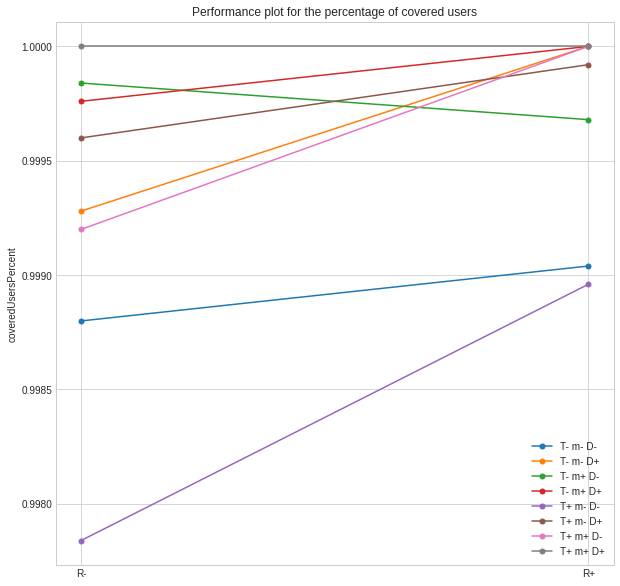

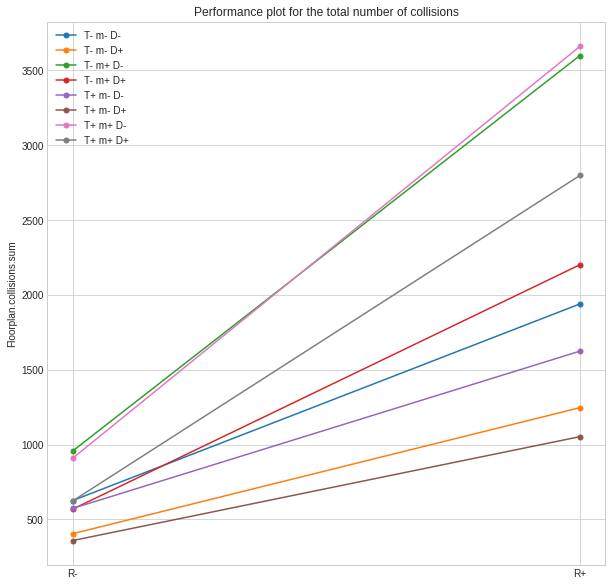

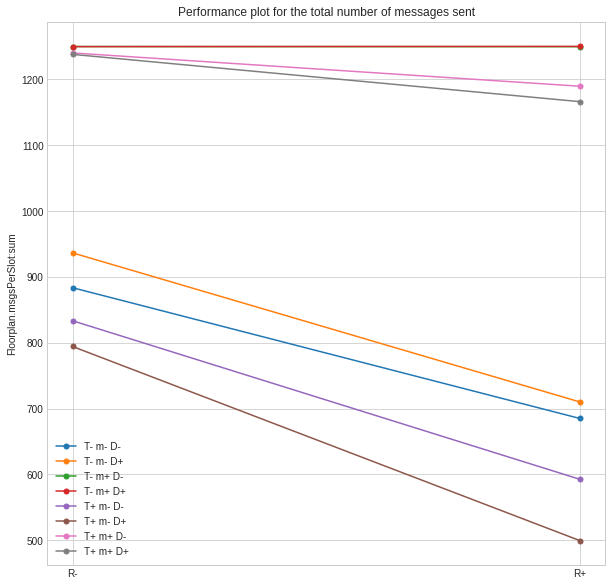

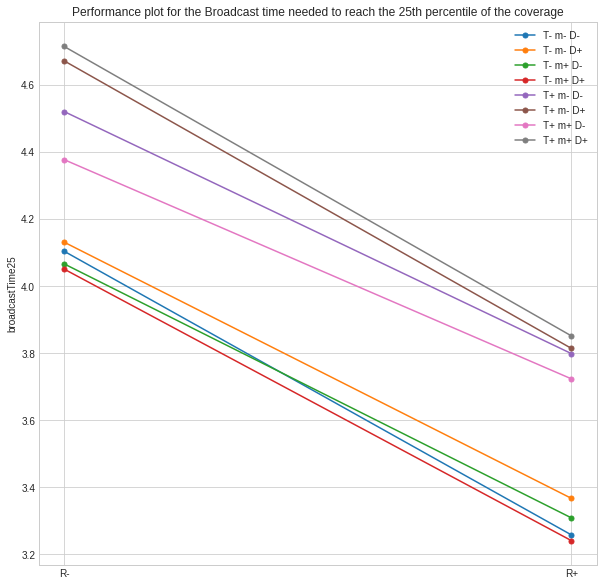

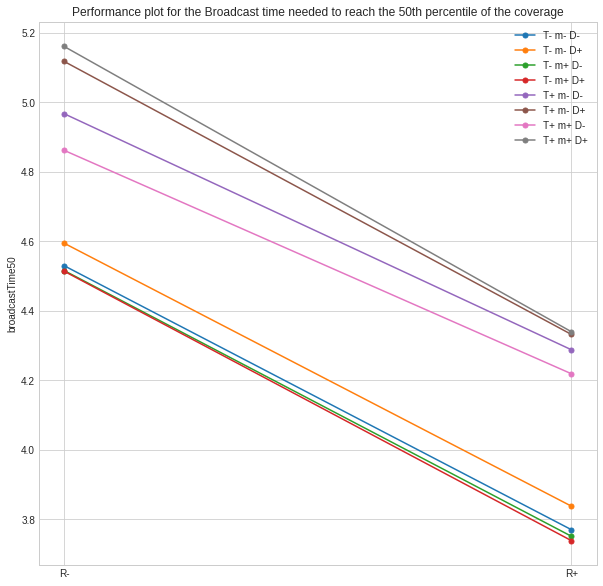

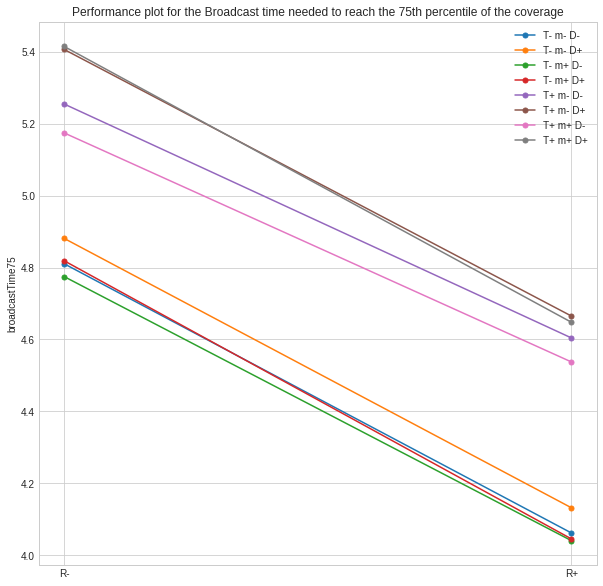

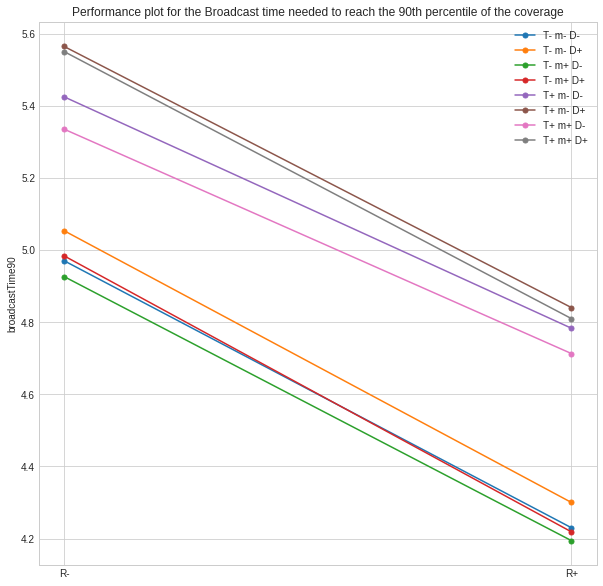

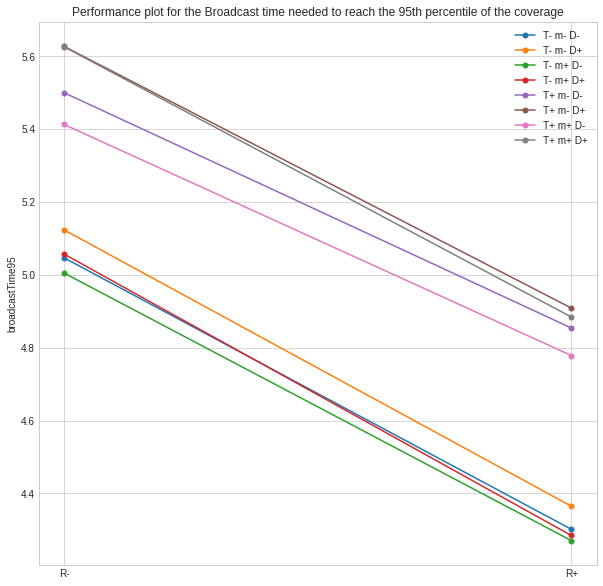

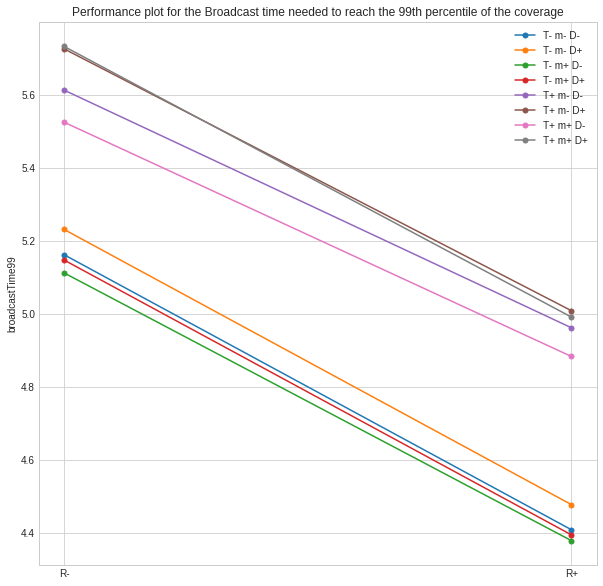

###########################

Plotting with T on the x axis...


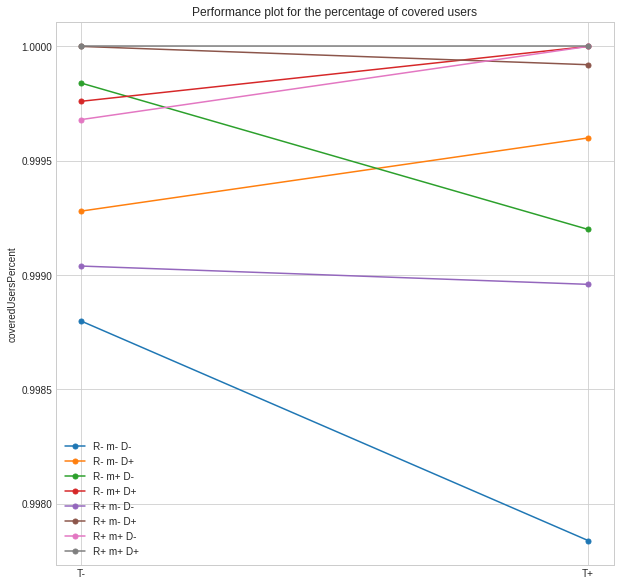

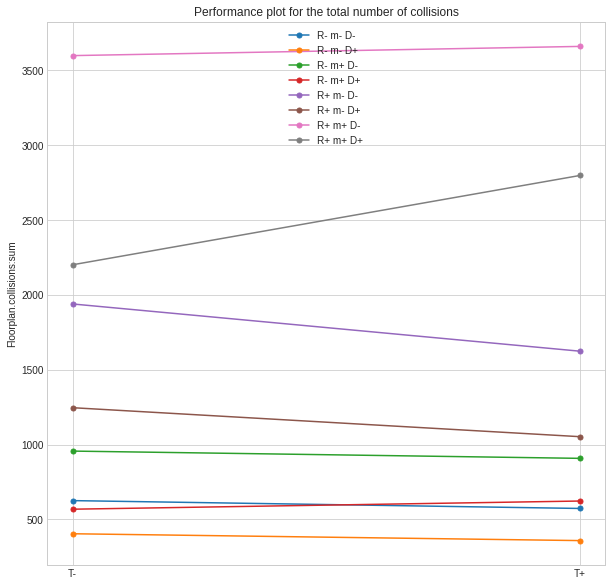

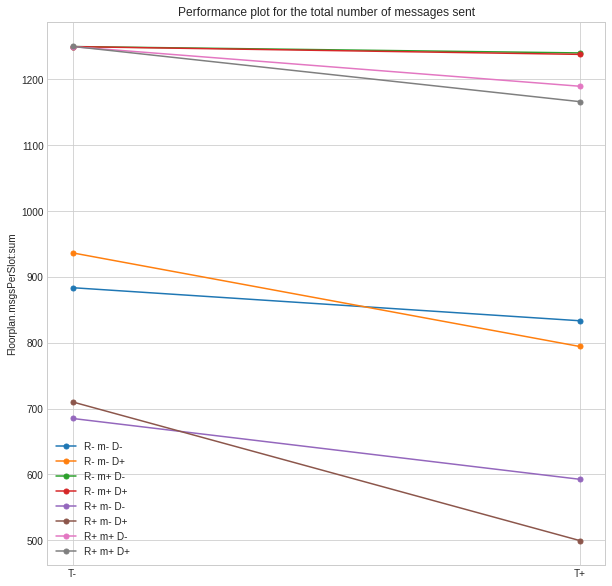

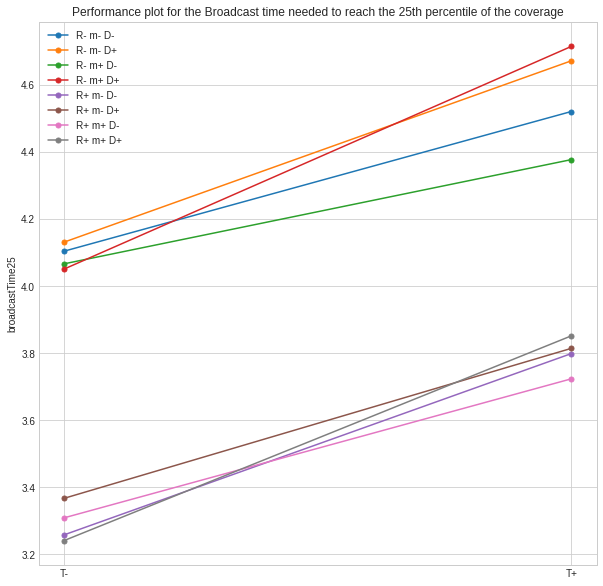

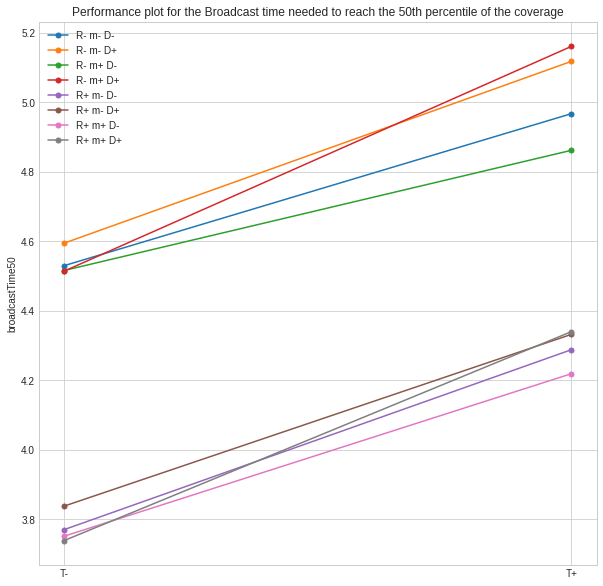

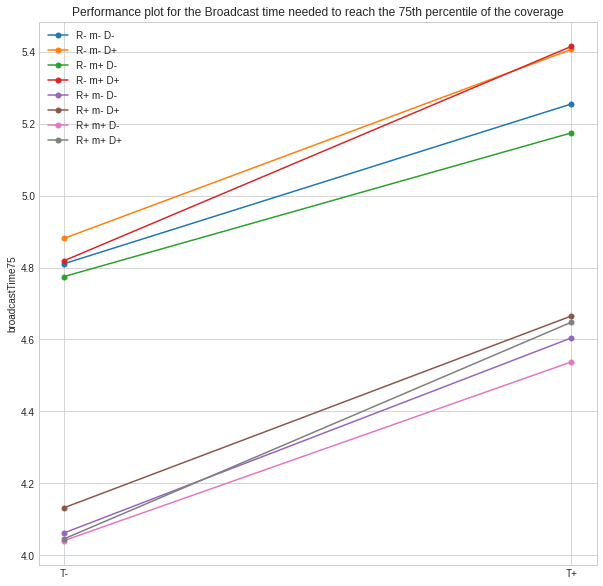

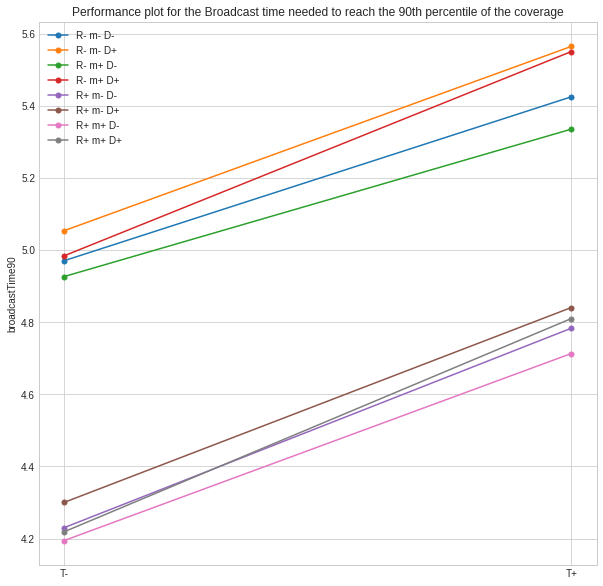

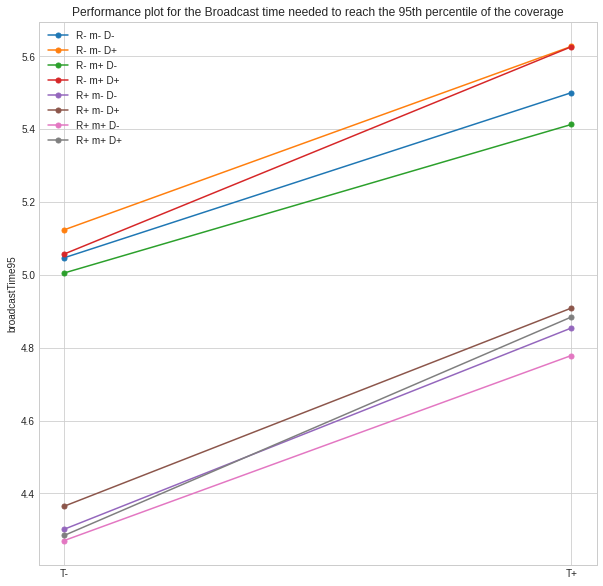

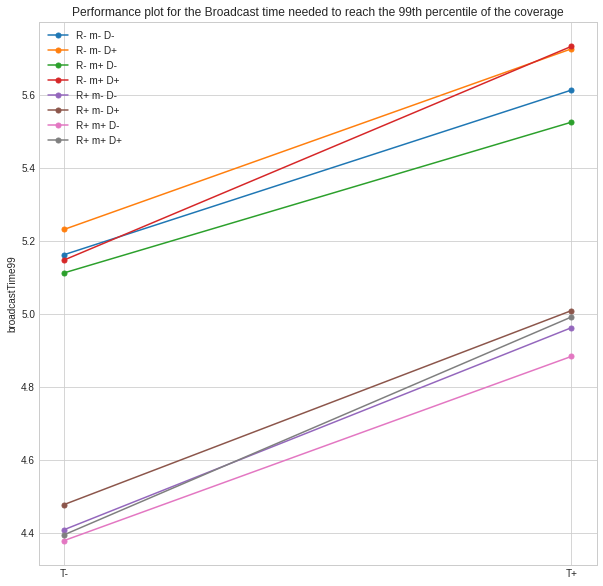

###########################

Plotting with m on the x axis...


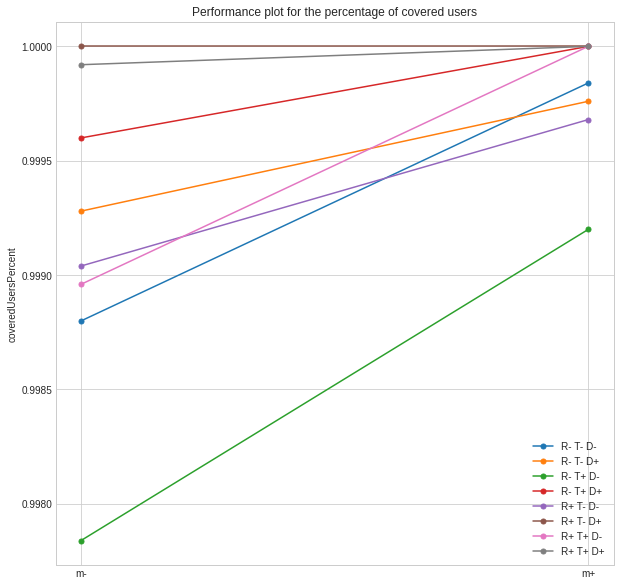

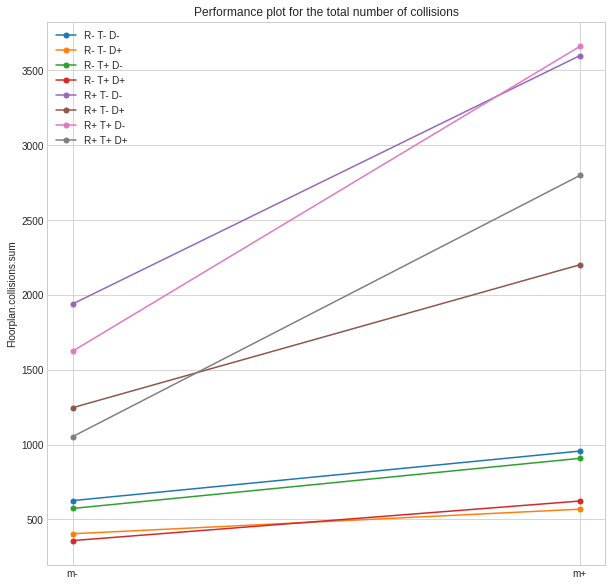

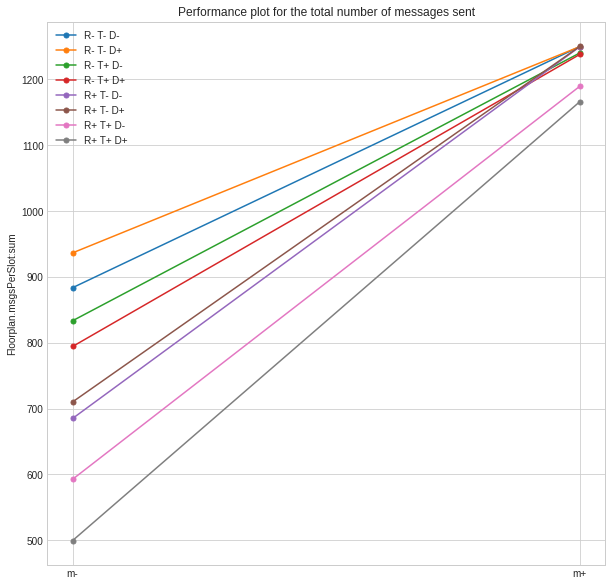

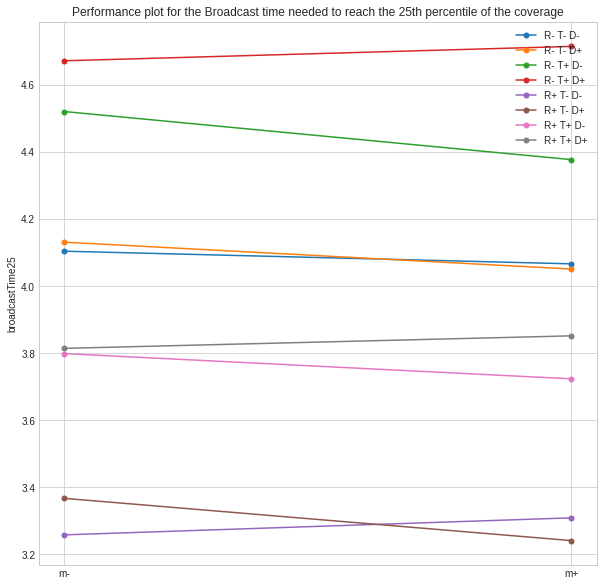

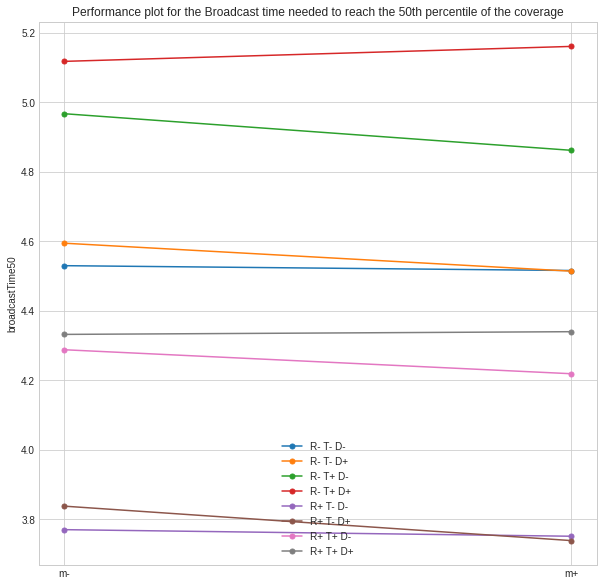

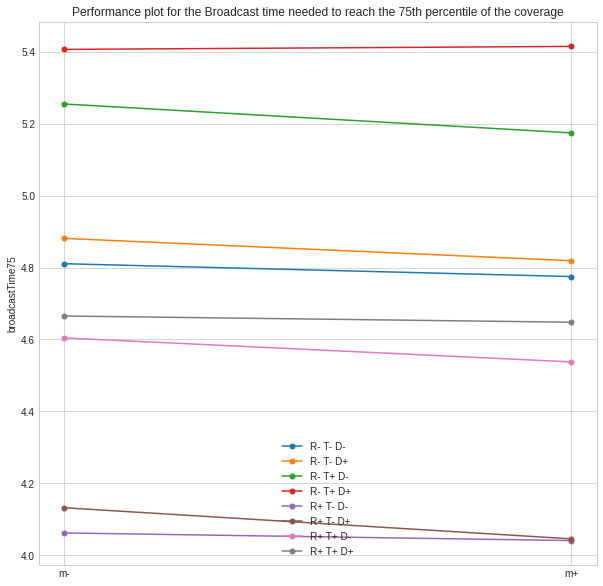

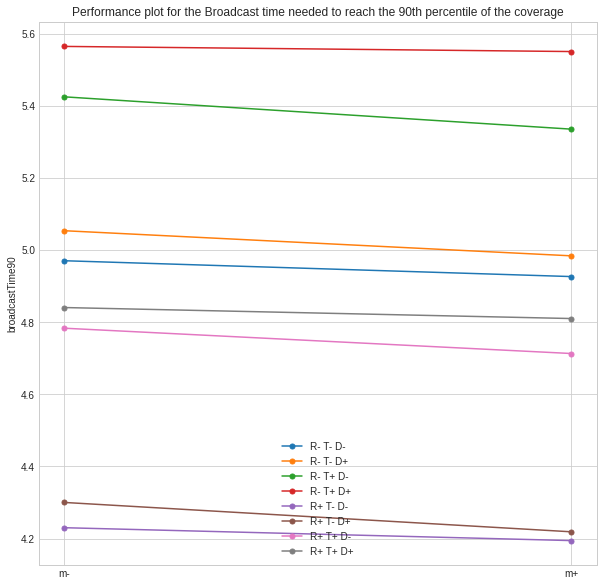

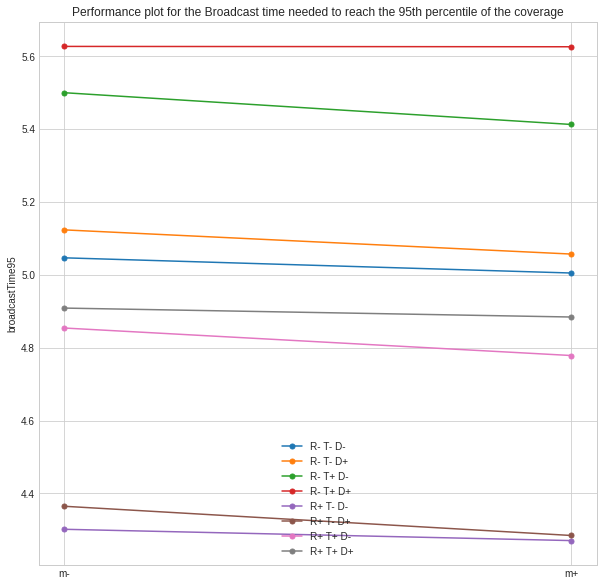

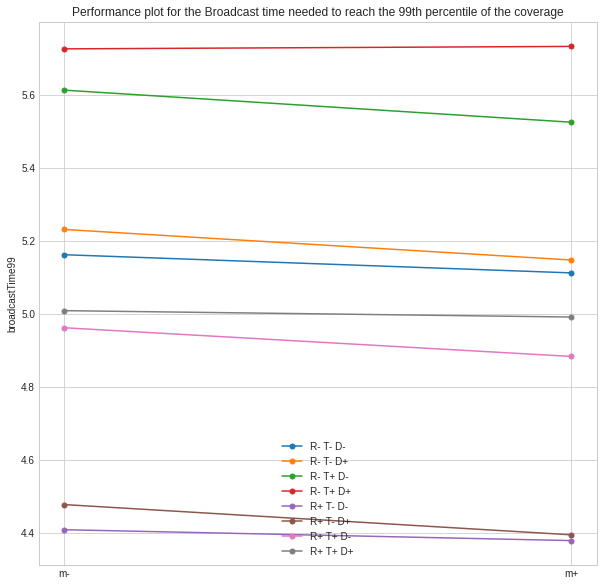

###########################

Plotting with D on the x axis...


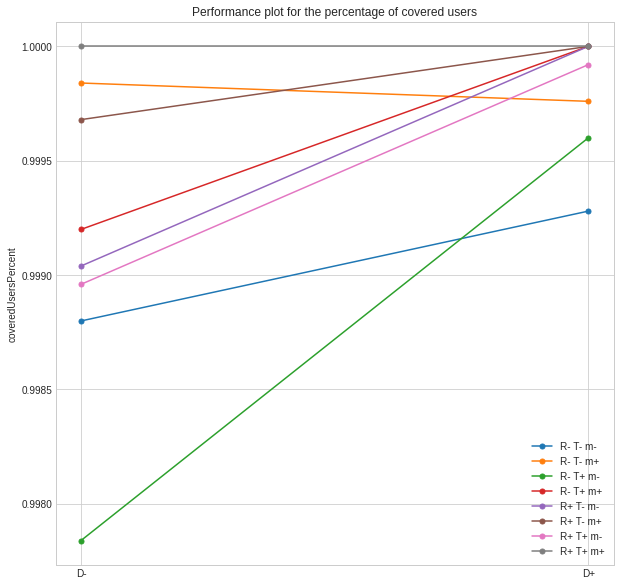

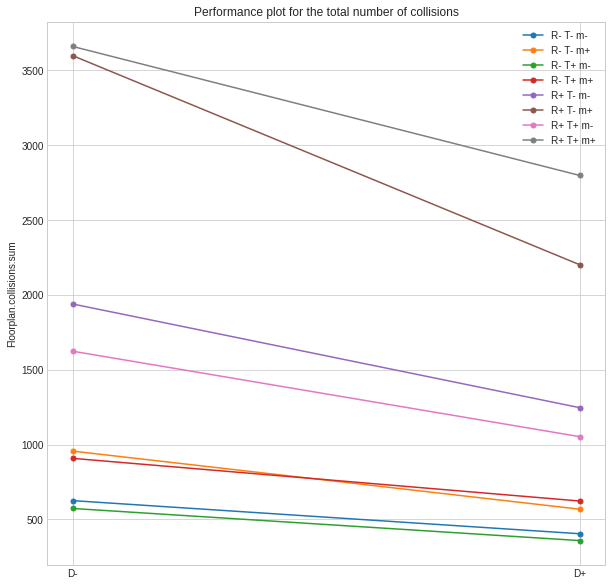

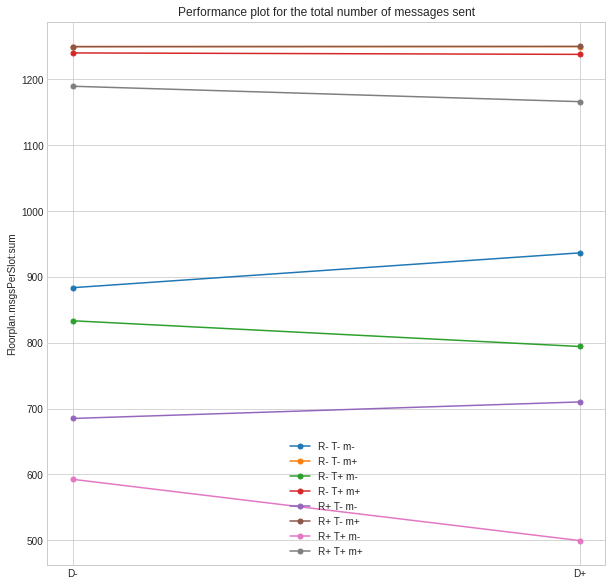

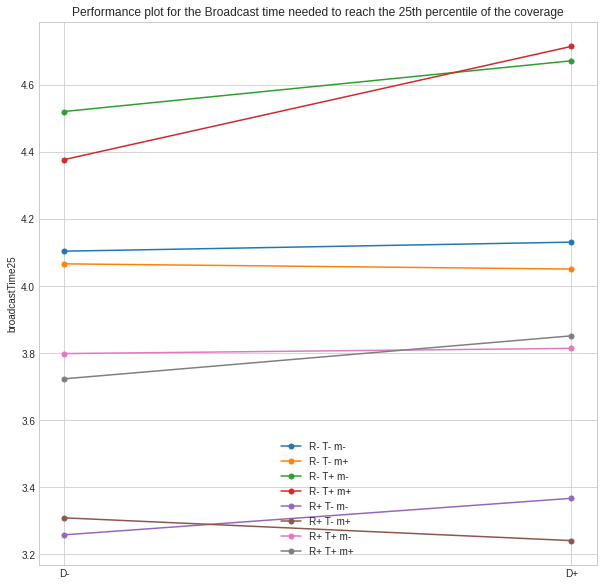

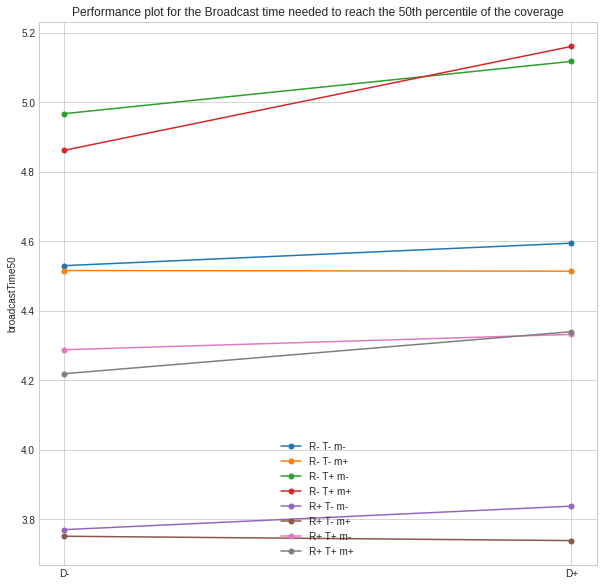

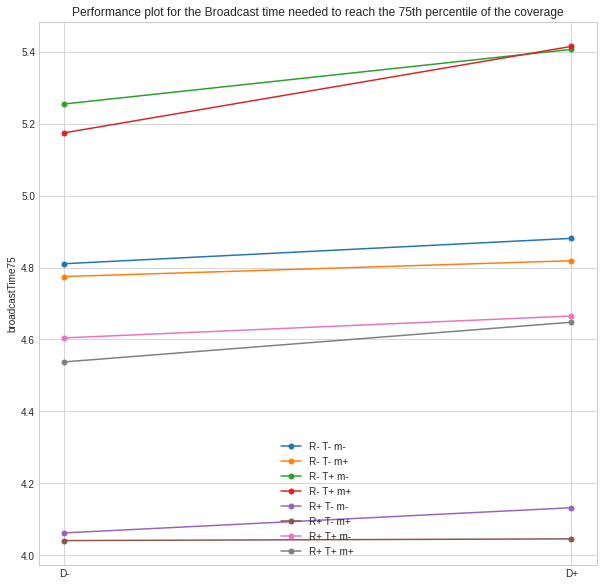

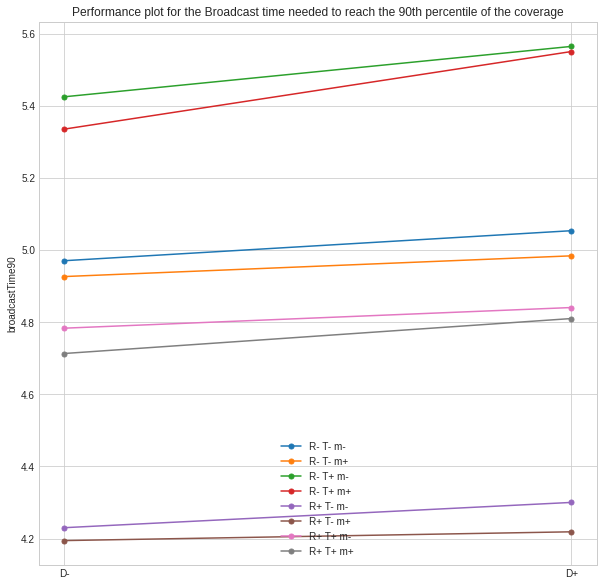

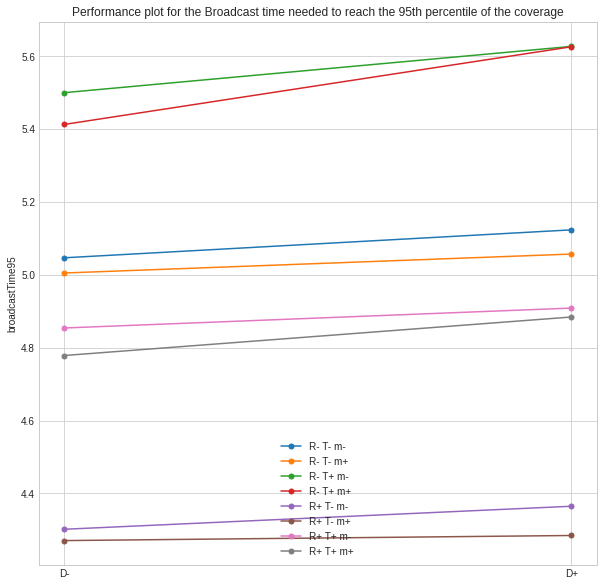

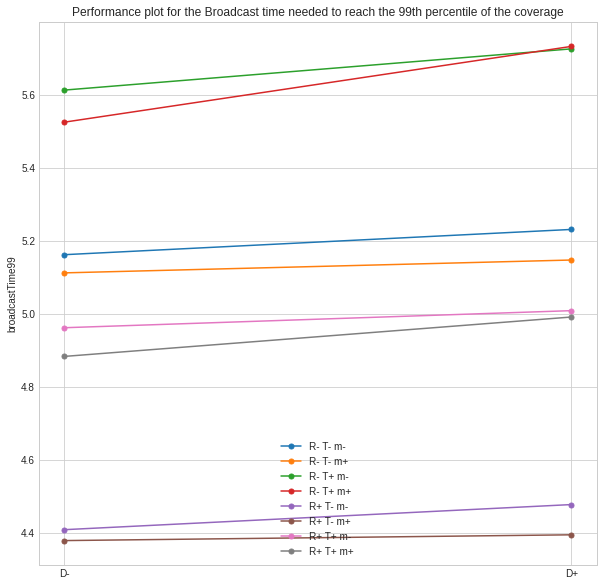

###########################



In [10]:
for xFactor in factors:
    print('Plotting with', xFactor, 'on the x axis...')
    xarr = np.array([-1, 1])
    idx = 0
    factorsMatrix.sort_values([xFactor] + [fac for fac in factors if fac != xFactor], inplace=True)
    for perfIndex, perfIndexDesc in perfIndexes:
        if perfIndex in skipped:
            continue
        ys = []
        fs = []
        for _, row in factorsMatrix.iterrows():
            y = np.sum(row[['I'] + combinedFactors].values * computeMatrices[idx].loc['Mean (Qi)', ['I'] + combinedFactors].values)
            fs.append(' '.join([f + str('+' if row[f] == 1 else '-') for f in [fac for fac in factors if fac != xFactor]]))
            ys.append(y)

        plt.figure(figsize=plotSize)
        plt.style.use(plotStyle)
        plt.xticks(xarr, (xFactor + '-', xFactor + '+'))
        ys = [y for y in zip(ys[:configsCount//2], ys[configsCount//2:])]
        for y, lbl in zip(ys, fs):
            yarr = np.array(y)
            plt.plot(xarr, yarr, linestyle='-', marker='.', markersize=10, label=lbl)
        plt.title('Performance plot for the ' + perfIndexDesc)
        plt.ylabel(perfIndex)
        plt.legend()
        if saveFigures:
            fig = plt.gcf()
            fig.savefig('figures/' + get_file_name(perfIndex) + '-' + xFactor + '-perfplot.png')
        plt.show()
        idx += 1
    print('###########################')
    print()